# Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization



***TODO***

***
- Lage plotfunksjon som kan lage ax=(1, 1) plot
- Lage funksjon som setter sammen plot slik at man kan få 2-3 enkle ved siden av hverandre

- Fikse alignment på flere bilder funksjonen. a, b, c er litt off.

text = 'https://devnote.in'

textwidth, textheight = draw.textsize(text)
***

## Contents
* [Introduction](#intro)
* [Theory behind methods](#method)
* [Analysing the CryptoPunks dataset](#dataset)
* [Denoising](#denoising)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="intro"></a>

\
\
\

An important subset of machine learning is dimentionality reduction. 

Examples include ...

One method of dimentionality reduction is non-negative matrix factorization (referred to as NMF throughout his notebook). In this project we will investigate this method. We begin by implementing it and testing on simple matrices, before using our tools to reduce the dimentionality of an image dataset. Towards the end of the notebook we attempt denoising with the method.

\
\
\
\
\
*A note on runtime etc...*\
\
\
\
\
\
\

Below we import the libraries needed for this project. 

In [80]:
# Libraries for math and plotting
import numpy as np
import matplotlib.pyplot as plt

## Image handling, files, timing and status bar
#%pip install opencv-python 
# Required to import cv2 !!!
import cv2
import os
import time

#import random SE OM NOTEBOOK KJØRER UTEN??

# Gives a progress bar 
from tqdm.notebook import tqdm

# Used to combine saved images
from PIL import Image

To reduce the amount of lines required to make plots, and avoid copying similar code to many cells, we create a standard plot function.

In [81]:
figure_count = 0

# def plot_funk( **kwargs..)






#figtext, auto numbering


## (TASK 1) Theory behind methods <a class="anchor" id="method"></a>


Non-negative matrix factorization (NMF) is a method for reducing the dimension of matrices, given by: 

$$A ≈ A_{NMF} = W H$$

Where $A$ is a $m\,\times\,n$ matrix that we want to reduce the dimensionality of. $W$ is a non negative $m\,\times\,d$ matrix and $H$ is a non negative $d\,x\,n$ matrix. $d$ is usually chosen to be considerably smaller than $n$ and $m$, so that $A$ can be represented in a more compact manner, but if $d$ is too small it can lead to an inadequate apptroximation of $A$. We will refer to $WH$ as the reconstruction of $A$.

\
\
\
\
***MORE about how to interpret the values in W and H. Extra insight, applications for spotify etc..., ..., "in out case"?***
\
\
\
\

The NMF of $A$ satisfies:

$$\min_{W, H} \lVert A - WH \rVert_F $$

such that $W$ and $H$ are non negative. There are infinetly many combinations of $W$ and $H$ that satisfy this condition, meaning that the NMF is non unique. We will use an iterative algorithm to calculate the NMF given by:

$$H_{k+1} ← H_k \odot (W^T_k A) \oslash (W^T_k W_kH_k)$$

$$W_{k+1} ← W_k \odot (AH^T_{k+1}) \oslash (W_kH_{k+1}H^T_{k+1})$$

This algortihm satisfies: 

$$\lVert A - W_{k+1}H_{k+1} \rVert_F \leqslant \lVert A - W_kH_k \rVert_F$$

Meaning that it converges to a local minimizer of the error, and therefore it may just find and approximate solution of the NMF, which again is an approximation of $A$. As a result there is a big room for error as the NMF might be a poor approximation of $A$ and our algorithm might not converge to a satisfying solution for the NMF.

a) 
    "We will show that if $A$ is non negative and $W$ and $H$ are initialized as positive, then all iterates $W_k$ and $H_k$ are also positive. This will by done by induction:  **Hvis a er 0 blir vel W_k og H_k også 0?, så vil må vel endre formulerinen litt?**\n",
    "\n",
    "Asssume $A$ is non negative and $W$ and $H$ are initialized as positive, and let $P(n)$ be the statement $W_k$ and $H_k$ are positive.\n",
    "\n",
    "The hypothesis clearly holds for the base case $P(0)$, as $W_0=W$ and $H_0=H$ being positive is part of our assumptions. \n",
    "\n",
    "Now we assume the induction hypothesis holds for $n=k$. We have that:\n",
    "\n",
    "$H_{k+1} ← H_k ⊙ (W^T_k A) ⊘ (W^T_k W_kH_k)$\n",
    "\n",
    "$W_{k+1} ← W_k ⊙ (AH^T_{k+1}) ⊘ (W_kH_{k+1}H^T_{k+1})$\n",
    "\n",
    "It is clear that $H_{k+1}$ is positive, as it is a product of $H_k$, $W_k$, $W^T_k$ and $A$, which are all positive under our assumptions and induction hypothesis. \n",
    "\n",
    "It follows that $W_{k+1}$ is positive, as it is also a product of only positive matrices. \n",
    "\n",
    "Hence the induction hypothesis holds for $n=k+1$. By induction it follows that $P(n)$ holds for all $n$ in $\mathbb{Z^+}$.

b) 

If $(W^T_k A) ⊘ (W^T_k W_kH_k)$ is a matrix of ones we see that when calculating $H_{k+1}$ we multiply every element of $H_k$ by $1$, meaning $H_{k+1}=H_k$, this is known as a fixed point. This happens when $W_kH_k=A$: 

$$(W^T_k A) ⊘ (W^T_k W_kH_k)=(W^T_k A) ⊘ (W^T_k A).$$

We know that ⊘ denotes elementvise division, so we are left with a matrix of the elements in $W^T_k A$ divided by themselves, that is clearly a matrix of ones.

c) vise blabla
\
\
\
\\

If either $W_0$ or $H_0$ are set to matrices containing only zeros, we can see from **ref Hk+1 Wk+1** that $H_k$ and $W_k$ converges to $0$ regardless of $A$. In other words $WH$ will never converge towards $A$, unless by chance $A$ is also a matrix of zeros. In out implementation we therefore radomise the initial values from the uniform dirstribution between 0 and 1, $U[0, 1]$.
 

**Implementation and testing**

We will now implement the NMF algorithm. To avoid division by 0 we will include a safe division constant $\delta$. 

In [82]:
#d, e, f

def NMF(V, d, delta = 1e-9, maxiter = 1000, seed = 4269):
    """
    Performs maxiter iterations of the NMF algorithm described above to find 
    matrices W and H such that V ≈ WH. 
    input:
        V: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        err: array of lenght maxiter+1 with Frodenius norms ||V-W_k@H_k||
    """

    if seed != 0:
        np.random.seed(seed)
        
    # Find dimensions of V
    m = np.shape(V)[0]
    n = np.shape(V)[1]
    
    # Initialize W and H with numbers from Unif(0, 1), and rescale by factor sqrt(mean(A)/d)
    random_numbers_01 = np.random.uniform(0.0, 1.0, m*d+d*n) # we need m*d+d*n numbers
    W = np.sqrt(np.mean(V)/d) * random_numbers_01[0:m*d].reshape((m, d))
    H = np.sqrt(np.mean(V)/d) * random_numbers_01[m*d:m*d+d*n].reshape((d, n))

    # Initialize the array err for storing the Frobenius norm ||V-WH||
    err    = np.zeros(maxiter+1)
    err[0] = np.linalg.norm(V - np.dot(W, H), 'fro')
    
    # Perform the iterations
    for k in tqdm(range(maxiter), leave = False):
        H *= np.dot(W.T, V) / (np.dot(W.T, np.dot(W, H)) + delta)
        W *= np.dot(V, H.T) / (np.dot(W, np.dot(H, H.T)) + delta)
        err[k+1] = np.linalg.norm(V - np.dot(W, H), 'fro')
    
    return W, H, err

To test that our algorithm works we define the following matrices:

$$ 
A_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix},\,\,\,\,\,
A_2 = \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix},\,\,\,\,\,
A_3 = \begin{bmatrix} 2 & 1 & 1 \\ 2 & 1 & 1 \\ 1 & 1 & 2 \end{bmatrix},\,\,\,\,\,
A_4 = \begin{bmatrix} 2 & 1 & 0 \\ 1 & 2 & 3 \\ 0 & 3 & 3 \end{bmatrix}.
$$

We begin by running the algorithm with $d=1$ for $A_1$ and $A_2$ for two differend seeds.

In [83]:
A1 = np.array([[1, 0],
               [0, 1]], dtype = "float")

A2 = np.array([[1, 2],
               [1, 1],
               [1, 2]], dtype = "float")

def A1A2_test(seeds, d = 1, dec = 3):
    for seed in seeds:
        W1, H1, err1 = NMF(A1, d, seed = seed)
        print(f"With A = A\u2081 =\n{np.round(A1, dec)}, \nwe find W = \n{np.round(W1, dec)},",
              f"\nH = \n{np.round(H1, dec)}, \nWH = \n{np.round(np.dot(W1, H1), dec)}.")
        print(f"This gives the Frobenius norm ||A\u2081-WH|| = {err1[-1]}")
        print(100*"-")

    for seed in seeds:
        W2, H2, err2 = NMF(A2, d, seed = seed)
        print(f"With A = A\u2082 =\n{np.round(A2, dec)}, \nwe find W = \n{np.round(W2, dec)},",
              f"\nH = \n{np.round(H2, dec)}, \nWH = \n{np.round(np.dot(W2, H2), dec)}.")
        print(f"This gives the Frobenius norm ||A\u2082-WH|| = {err2[-1]}")

        print(100*"-")
    
seeds = [42, 69]
# A1A2_test(seeds)

Uncommenting the bottom line yields the results presented in the table below. 

|                |        $A$        |       $W$       |       $H$       |       $WH$      |$\lVert{A-WH}\rVert_F$|
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| seed 1 | \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} | \begin{bmatrix} 0.265 \\ 0.672 \end{bmatrix} | \begin{bmatrix} 0.507 & 1.288 \end{bmatrix} | \begin{bmatrix} 0.134 & 0.341 \\ 0.341 & 0.866 \end{bmatrix} | $1.0$ |  
| seed 2 |                                              | \begin{bmatrix} 0.209 \\ 0.572 \end{bmatrix} | \begin{bmatrix} 0.564 & 1.541 \end{bmatrix} | \begin{bmatrix} 0.118 & 0.323 \\ 0.323 & 0.882 \end{bmatrix} | $1.0$ 
| seed 1 | \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix} | \begin{bmatrix} 1.078 \\ 0.658 \\ 1.078 \end{bmatrix} | \begin{bmatrix} 1.021 & 1.803 \end{bmatrix} | \begin{bmatrix} 1.1 & 1.943 \\ 0.671 & 1.186 \\ 1.1 & 1.943 \end{bmatrix} | $0.411$ |
| seed 2 |                                               | \begin{bmatrix} 0.869 \\ 0.530 \\ 0.869 \end{bmatrix} | \begin{bmatrix} 1.266 & 2.236 \end{bmatrix} | \begin{bmatrix} 1.1 & 1.943 \\ 0.671 & 1.186 \\ 1.1 & 1.943 \end{bmatrix} | $0.411$ | 

***DISCUSS***
\
\
\
\
\
\what is same
\
\
\
\
\



In [84]:
#e
# A1A2_test([4269], d = 2, dec = 3)

1e)

|        $A$        |       $W$       |       $H$       |       $WH$      |$\lVert{A-WH}\rVert_F$|
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} | \begin{bmatrix} 0.11 & 0 \\ 0 & 0.132 \end{bmatrix} | \begin{bmatrix} 9.109 & 0 \\ 0 & 7.567 \end{bmatrix} | \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} | $1.718\cdot10^{-10}$ |  
| \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix} | \begin{bmatrix} 0.265 & 0.38 \\ 0.079 & 0.463 \\ 0.265 & 0.38 \end{bmatrix} | \begin{bmatrix} 0.892 & 5.871 \\ 2.007 & 1.163 \end{bmatrix} | \begin{bmatrix} 1 & 2 \\ 1 &  1 \\ 1 & 2 \end{bmatrix} | $6.589\cdot 10^{-10}$ |

In [85]:
#f FIND ranks
A3 = np.array([[2, 1, 1],
               [2, 1, 1],
               [1, 1, 2]], dtype = "float")

A4 = np.array([[2, 1, 0],
               [1, 2, 3],
               [0, 3, 3]], dtype = "float")

print(f"\u03C3(A\u2083) = \u007b{np.linalg.eig(A3)[0][0]}, {np.linalg.eig(A3)[0][1]}, {np.linalg.eig(A3)[0][2]}\u007d")
print(f"\u03C3(A\u2084) = \u007b{np.linalg.eig(A4)[0][0]}, {np.linalg.eig(A4)[0][1]}, {np.linalg.eig(A4)[0][2]}\u007d\n")

print(f"np.linalg.matrix_rank(A3) returns {np.linalg.matrix_rank(A3)}")
print(f"np.linalg.matrix_rank(A4) returns {np.linalg.matrix_rank(A4)}")

σ(A₃) = {4.000000000000002, 1.0000000000000002, -5.063800617498565e-16}
σ(A₄) = {-0.7577017654507552, 2.0991149902691513, 5.658586775181606}

np.linalg.matrix_rank(A3) returns 2
np.linalg.matrix_rank(A4) returns 3


From the space of eigenvalues, $\sigma(A_3)$, we see that 0 is an eigenvalue of the matrix $A_3$. It only has two non-zero eigenvalues, and is therefore a rank $2$ matrix. $\sigma(A_4)$ shows that $A_4$ has three non-zero eigenvalues, so it is a rank 3 matrix.  

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

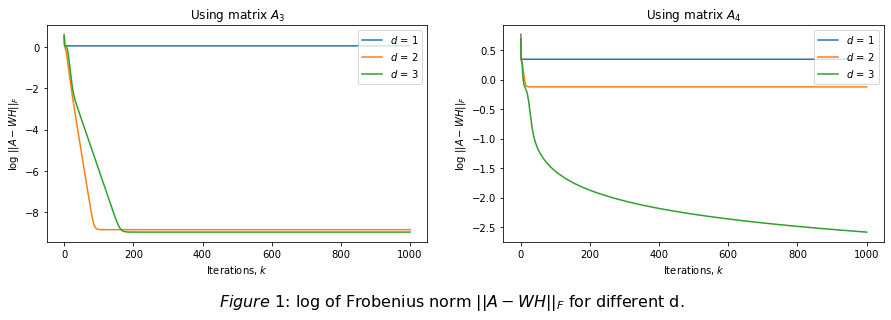

In [86]:
#g

"""
g) For A3 and A4, run the NMF algorithm for d = 1, d = 2 and d = 3 and
plot ∥A − WkHk∥F as a function of number of iterations in two separate plots
(one for A3 and one for A4). Scale the y-axis logarithmically, using for example
plt.semilogy. Is equation (17) satisfied? How do the results depend on d?
"""

d_vals = [1, 2, 3]
A3_error_arrays = []
A4_error_arrays = []
for d in d_vals:
    A3_error_arrays.append(NMF(A3, d)[2])
    A4_error_arrays.append(NMF(A4, d)[2])


    
### DETTE skal gjøres om til en generell plotfunksjon
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
for i in range(len(d_vals)):
    axs[0].plot(np.log10(A3_error_arrays[i]), label = r"$d$ = " + f"{d_vals[i]}")
    axs[1].plot(np.log10(A4_error_arrays[i]), label = r"$d$ = " + f"{d_vals[i]}")

axs[0].set_title(r"Using matrix $A_3$")
axs[1].set_title(r"Using matrix $A_4$")

axs[0].legend(loc = "upper right")
axs[1].legend(loc = "upper right")

axs[0].set_xlabel(r"Iterations, $k$")
axs[0].set_ylabel(r"log $||A-WH||_F$")
axs[1].set_xlabel(r"Iterations, $k$")
axs[1].set_ylabel(r"log $||A-WH||_F$")


figure_count += 1
txt = f"$Figure$ ${figure_count}$: " + r"log of Frobenius norm $||A-WH||_F$ for different d."
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize = 16)
plt.show()


From the plots we see ...

Satisfy ***REF***

$$\lVert A - W_{k+1}H_{k+1} \rVert_F \leqslant \lVert A - W_kH_k \rVert_F$$

***Discuss d dependence***


We have now developed the tools necessary to begin exploring a larger dataset. 

## (TASK 2) Analysing the CryptoPunks dataset <a class="anchor" id="dataset"></a>

We will now turn our attention to image ... ...

***EXPLAin how images are stored +++, page 13 in task***
\
\
\
\
\
\




The dataset for this project consists of 10 000 images. Of these we will sample $N=500$ random images to ensure we get unique results. We use a predeterminded seed to ensure the results won't change if the notebook is restarted. The load_images function was handed out, but has been modified slightly to pick images before loading them into the notebook. ***LATER WE WILL VARY N???*** 

In [87]:
def load_images(N, seed = 4269):
    """
    Loads N random images from cryptopunk dataset. Use the same seed to get the same
    selection each time. 
    Input:
        integer: N, number of images to load
        integer: seed for random sampling
    Output:
        array: faces, (24,24,4,N) numpy array containing images
    """
    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Chose N random image numbers
    M = 10000 # number of images to choose from
    np.random.seed(seed)
    image_number_choice = np.random.choice(np.arange(0, M),N, replace = False)
        
    # Iterate over folders
    for i in range(len(image_number_choice)):
        im_path = f"./imgs/imgs/imgs/{image_number_choice[i]}.png"
        im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
        faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

    return faces

# Load N = 500 faces
faces500 = load_images(500)

# Check that the shape is correct
print("The face array has shape: ", faces500.shape)

The face array has shape:  (24, 24, 4, 500)


Below is handed-out code for plotting the images we have loaded. 

In [88]:
def plotimgs(imgs, nplot = 8, rescale = False, filename = None, figsize = (16, 16), number_color = "black"):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = figsize

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgrey")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        if nplot > 1:
            axes[i,j].axis('off')
        else:
            axes.axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            if nplot > 1:
                axes[i,j].imshow(scaled_img)
            else:
                axes.imshow(scaled_img)
        else:
            if nplot > 1:
                axes[i,j].imshow(imgs[:,:,:,idx])
            else:
                axes.imshow(imgs[:,:,:])
        
        # Add numbers to each image
        if nplot > 1 and number_color:
            axes[i, j].text(0, 4, f"{idx+1}", color = number_color, fontsize = 20)

    # Tight layout so images will appear closer together
    plt.tight_layout()
    
    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

def plotimgs_merge(filetitles, merged_title, image_texts = ["a)", "b)", "c)"]):
    """
    Plots images side by side. This lets us combine images and serves as a workaround to 
    jupyters limitation of one image attachment per markdown cell.
    input:
        filetitles: list of titles of images to plot
    """
    num_of_imgs = len(filetitles) # Number of images
    size = 200 # x and y dimension of images produced with figsize (16, 16)

    # Load images
    images = [Image.open(filetitle + ".png") for filetitle in filetitles]
    
    # Resize and merge the images
    x_size = int(size*(1+1/20))*num_of_imgs + int(size*(1/20))
    y_size = int(size*(1+3/20)) # double space below for figtext
    
    merged_Image = Image.new('RGB', (x_size, y_size), (250, 250, 250))
    for index, image in enumerate(images):
        # Resize image
        image = image.resize((size, size))
        
        # Place image in merged image
        x_coord = int(size*(1+1/20))*index + int(size*(1/20))
        y_coord = int(size*(2/20))
        merged_Image.paste(image, (x_coord, y_coord))
        
    # Add text above each image:
    draw = ImageDraw.Draw(merged_Image)
    for index, text in enumerate(image_texts):
        x_coord = int(size*(1/20) + size/2) + index*(size*(1+1/20))
        y_coord = int(size*(1/20))
        draw.text((x_coord, y_coord), text, (0,0,0))
    
    # Save image
    merged_Image.save(merged_title + ".png","PNG")
    
plotimgs_merge(["punks_basis_d16", "punks_basis_d64", "punks_basis_d144"], "basises")
plotimgs_merge(["16punks_d16", "16punks_d64", "16punks_d144"], "multiple_16punks")



## MULIGHET for å skrive på a), b), c) etc...
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

img = Image.open("merged_image.jpg")
draw = ImageDraw.Draw(img)
draw.text((0, 0),"Sample Text",(0,0,0))
img.save('sample-out.jpg')



**First look at the dataset**

2a) We now have all we need to investigate ...

In [89]:
# plotimgs(faces500, nplot = 8, filename="punks_2a.png")

The code above gives the image below. 

<img src=punks_2a.png alt="Drawing" style="width: 500px;"/>

We observe ... 

COMMENTs on 2a)

**Converting the dataset**

To apply NMF we want to turn our (24, 24, 4, 500) array into a $m\times n$ matrix. For this project we only care about the color channels. We will therefore split the RGBA images into a RGB array of shape (24, 24, 3, 500) and a opacity array (24, 24, 1, 500) wich we store for the plotting the reconstructed images after running out algorithm. Below we define a function to split the channels and reshape the RGB array into a $1728\times N$ matrix. We also define a function to reshape a $1728\times N$ back into an RGB array, and optionaly remerge with the opacity.

In [90]:
def split_and_reshape(faces):
    #input: 24x24x4xN array of stored images
    #output: 1728xN array of with rgb values for the images without opacity, 24x24x500 array of opacity for images 
    faces_opacity = faces[:,:,3,:]
    faces_rgb = faces[:,:,:3,:]
    shape = faces_rgb.shape
    
    # Clever reshape "trick". This is the matrix we will apply the NMF to
    N = faces.shape[-1]
    faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)
    
    return faces_reshaped, faces_opacity

def merge_and_reshape(reshaped, opacity = np.array([])):
    #input: 1728xN array of with rgb values for the images without opacity, 24x24xN array of opacity for images 
    #output: 24x24x4xN array of images
    N = int(reshaped.size/1728)
    faces = np.reshape(reshaped, (24,24,3,N))
    if opacity.size > 0:
        opacity = np.reshape(opacity, (24,24,1,N))
        faces = np.concatenate((faces, opacity), axis=2)
    
    faces = np.where(faces<=1, faces, 1)
    
    return faces

# We reshape the faces with our function
faces500_reshaped, opacity500 = split_and_reshape(faces500)

# Check that the shape is correct
print("The reshaped face array has shape: ", faces500_reshaped.shape)

# Test the merge_and_reshape function
faces500_merge_test = merge_and_reshape(faces500_reshaped, opacity500)
print("The remerged face array has shape: ", faces500_merge_test.shape)
# plotimgs(faces_merge_test, 8, filename="merge_testpunks.png")

The reshaped face array has shape:  (1728, 500)
The remerged face array has shape:  (24, 24, 4, 500)


We
\
\
\
\
\
\
\
\






**The *average* face**

2b) We first ... calculate mean ... usefull?

np.linalg.matrix_rank(faces500_reshaped) returns 377




(24, 24, 4, 500)
(24, 24, 4)


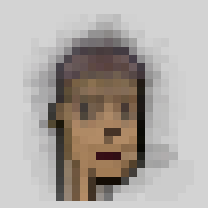

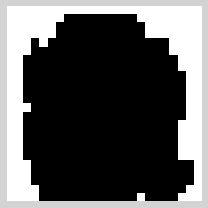

In [91]:
print(f"np.linalg.matrix_rank(faces500_reshaped) returns {np.linalg.matrix_rank(faces500_reshaped)}\n\n\n\n")

### np.linalg.svd(faces500_reshaped) SKAL vi fikse den? 
# https://mattelab2022v.math.ntnu.no/t/project-3-task-2b/1212/2


#2b) The mean face


print(faces500.shape)
mean_face = np.mean(faces500, axis = -1)
print(mean_face.shape)
plotimgs(mean_face, 1, filename="meanface.png", figsize = (3, 3))


mean_face[:,:,0] = mean_face[:, :, 3] == 0
mean_face[:,:,1] = mean_face[:, :, 3] == 0
mean_face[:,:,2] = mean_face[:, :, 3] == 0
mean_face[:, :, 3] = 1
plotimgs(mean_face, 1, filename="0avg.png", figsize = (3, 3)) # hvit betyr her gjennomsnitt lik 0




2b) 

Useful info?

Pixels with no opacity for all?

Rank of image matrix???

**NMF with $d=64$**

2c)

***c) Calculate the NMF of the 3 color channels as explained above using d = 64. Plot
the columns of W interpreted as RGB images (each columns should be a 24×24×3
vector so you can use the handed out plotting function after reshaping). Explain
and discuss what you see. Does the NMF capture the important features of the
dataset? You can also try with different values for d to see how this affects the
results.***

In [92]:
#2c, 2d

def reconstruction_images(d, maxiter = 1000, N = 500, basis_color = False, faces_to_plot=8):
    # Load and Reshape
    faces_reshaped_d, opacity_d = split_and_reshape(load_images(N))
    
    # Perform NMF algorithm
    W_d, H_d, err_d = NMF(faces_reshaped_d, d, maxiter = maxiter)
    
    # Reshape and plot basis
    W_columns_d = merge_and_reshape(W_d) 
    plotimgs(W_columns_d, int(d**(1/2)), filename=f"punks_basis_d{d}.png", number_color = basis_color)

    # Reshape and plot faces
    img_reconstructed_d = merge_and_reshape(np.dot(W_d, H_d), opacity)
    plotimgs(img_reconstructed_d, faces_to_plot, filename=f"{faces_to_plot**2}punks_d{d}.png")
    
# reconstruction_images(8**2, basis_color = "white")

# # Trying different d values
# reconstruction_images(4**2, faces_to_plot=4)
# reconstruction_images(8**2, faces_to_plot=4)
# reconstruction_images(12**2, faces_to_plot=4)

The code above ...

<img src=punks_basis_d64.png alt="Drawing" style="width: 500px;"/>


We also tried different values for $d$:


**Global and local minima**

***Vi bør kanskje si noe om vi tror vi treffer global??***

\

\\
\
\
\
\
\
\



38.795608818092425


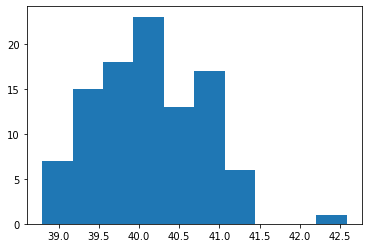

In [102]:
## KUNNE vi brukt en bedre seed??

def seed_test(number_of_seeds = 100, maxiter = 1000, d = 64, N = 500, seed = 4269, data_title = False):
    
    # Load and split faces
    faces_reshaped_s = split_and_reshape(load_images(N))[0] # index 1 is the opacity channel
    
    # Prepare array of seeds
    np.random.seed(seed)
    seeds = np.random.randint(4269, size = number_of_seeds)
    
    # Initialise list to store the different reconstructions errors
    reconstruction_errors = []
    
    # Do NMF simulation and append reconstruction for each seed
    for i in tqdm(range(number_of_seeds)):
        W_s, H_s, err_s = NMF(faces_reshaped_s, d, maxiter = maxiter, seed = seeds[i])
        reconstruction_errors.append(err_s[-1])
    
    # Save the data
    if data_title:
        np.savez(data_title, seeds = seeds, reconstruction_errors = reconstruction_errors)

# seed_test(data_title = "100seeds.npz")
reconstruction_errors = np.load("100seeds.npz")["reconstruction_errors"]

# Plot histogram
plt.hist(reconstruction_errors)
print(min(reconstruction_errors)

2c) important features

2d) 

***d) With d = 64, calculate the 64 reconstructions W H corresponding to the images
you plotted in 2a) and plot the reconstructions (again, you can use the handed out
plotting function after reshaping). Are the reconstructions overall good? How do
the reconstructions deviate from the original images (if they deviate at all)? In
particular, are all features of the images equally well reconstructed?***


**Reconstructing the dataset**

|d=16|d=64|d=144|
:-------------------------:|:-------------------------:|:-------------------------:
<img src=16punks_d16.png alt="Drawing" style="width: 500px;"/>  |  <img src=16punks_d64.png alt="Drawing" style="width: 500px;"/>  |  <img src=16punks_d144.png alt="Drawing" style="width: 500px;"/>  |


Discuss deviation

**Convergence**

2e) 

***e) For each iteration k, calculate ∥A−WkHk∥F and plot it as a function of iterations
similarily to what you did in Task 1, but now for d = 16, 32, 64. Are the results
reasonable? Does it look like the algorithm has converged?***

In [101]:
#2e) 

def error_sim(faces_reshaped, maxiter = 1000, d_vals = [16, 32, 64]):
    image_error_arrays = []
    for d in tqdm(d_vals, leave = False):
        image_error_arrays.append(NMF(faces_reshaped, d, maxiter = maxiter)[2]) # øke maxiter

    ### DETTE skal gjøres om til en generell plotfunksjon
    fig, ax = plt.subplots(figsize = (15, 4))
    for i in range(len(d_vals)):
        ax.plot(np.log10(image_error_arrays[i]), label = r"$d$ = " + f"{d_vals[i]}")

    ax.legend(loc = "upper right")
    ax.set_xlabel(r"Iterations, $k$")
    ax.set_ylabel(r"log $||A-WH||_F$")

    figure_count = 2
    txt = f"$Figure$ ${figure_count}$: " + r"log of Frobenius norm $||A-WH||_F$ for different d for ........"
    plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize = 16)
    plt.show()

# error_sim(faces500_reshaped, maxiter = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

39.62027723133324


2e) discuss

**2f) Reconstruction error and feature number $d$**

We will now do NMF calculation for a wide range of $d$ to investigate how the reconstruction error, $\lvert\lvert A - WH \rvert\rvert_F$. We expect that the error is reduced as we capture more features in matrix $W$. 
\
\
\
\
\
\
\
\
\

***f) For a wide range of d, for example d = 16, 64, 128, 256, do an NMF and calculate
∥A−W H∥F
9
. Make sure you are using a high number of maximum iterations (at
least 1000 iterations), and if your computing resources and time allows it, try to
use more values for d. Plot this quantity as a function of d. Discuss the resulting
plot. Specifically, how would you expect ∥A − W H∥F to depend on d?***

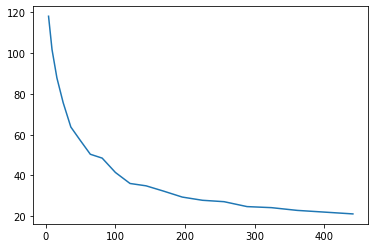

In [78]:
#2f)

def final_error_sim(d_vals, N = 500, maxiter = 1000, noise_level = 0, data_title = False):
    
    # Load, reshape and add noise to images
    faces_es          = load_images(N)
    faces_reshaped_es = split_and_reshape(faces_es)[0]
    faces_r_noisy_es  = split_and_reshape(faces_es)[0] # We need faces_reshaped_es for error comparison
    
    # We add this possibility to reuse the function later. 
    if noise_level != 0:
        faces_r_noisy_es = add_noise(faces_reshaped_es, noise_level)
    
    # Initialise arrays for final errors
    final_error_es = np.zeros(len(d_vals))

    # We do the simulation for all the d values
    for i in tqdm(range(len(d_vals)), leave = False):
        W_es, H_es, err_es = NMF(faces_r_noisy_es, d_vals[i], maxiter = maxiter)
        final_error_es[i]  = np.linalg.norm(faces_reshaped_es - np.dot(W_es, H_es), 'fro')
    
    ## SAVE DATA
    if data_title:
        np.savez(data_title, d_vals=d_vals, final_error = final_error_es)
        
    return final_error
    
# ## To run this cell uncomment the line below. Warning: run at own risk. Reduce some parametres to reduce rumtime.
# maxiter = 1000
# d_vals = [i**2 for i in range(2, 22)]
# final_error = final_error_sim(d_vals, maxiter = maxiter)#, data_title = "2f.npz")

# Load data from commented line
data = np.load("2f.npz")
d_vals      = data['d_vals']
final_error = data['final_error']

# Plot the results
######## PLOT FUNCTION HERE
plt.plot(data['d_vals'], data['final_error'])


2f) discuss

## (Task 3) Denoising <a class="anchor" id="denoising"></a>

We will now add noise ...

We model the noise as:

$$A_{\textrm{noisy}} = A + \sigma E,$$

where $\sigma > 0 $ is our *noise level*, and $E$ sampled from $\mathcal{N}(0, 1)$. Below is the handed out function to add noise to the images.

In [ ]:
def add_noise(imgs_reshaped, sigma = 0.1, seed = 4269):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = imgs_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    np.random.seed(seed)
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

***Vi kan nå legge til støy til bildene våre, legge på opasitetskanalaen igjen og plotte. Dere må gjøre noe lignende etter dere har anvendt NMF og ønsker å plotte rekonstruksjoner med opasitet.***

3a)\ 
\
\
\
\
\



In [ ]:
faces500_reshaped_noisy = add_noise(faces500_reshaped, sigma = 0.1)

# Calculate the error of the noisy images
noise500_error = np.linalg.norm(faces500_reshaped_noisy - faces500_reshaped, 'fro') 
print(noise500_error)

# For plotting noisy images we add the opacity
faces500_noisy = merge_and_reshape(faces500_reshaped_noisy, opacity500)
plotimgs(faces500_noisy)

**NMF -> ADD COOLER TITLEs**

3b) 

***• b) Using the same approach as task 2, fit an NMF using d = 64 to the noisy images.
Plot the columns of W and the reconstructions like you did in 2c) and 2d). Are
the reconstructions less noisy than the noisy images? Compare the columns of W
and the reconstructions to the results you got in task 2.***

In [ ]:
d = 64
W_noisy, H_noisy, err_noisy = NMF(faces_reshaped_noisy, d, maxiter = 100) # øke maxiter!!

W_columns_noisy = merge_and_reshape(W_noisy)
plotimgs(W_columns_noisy, 8, filename="punks_basis_noisy.png", figsize = (12, 12))

images_noisy_reborn = merge_and_reshape(np.dot(W_noisy, H_noisy), opacity)
plotimgs(images_noisy_reborn, 8, filename="punks.png", figsize = (12, 12))


**sss**

3c) 

***c) As you did in task 2, fit an NMF to the noisy images for a wide range of d,
calculate the reconstruction error ∥A − W H∥F (important: A is here the original
images, NOT the noisy images). Plot this with the error you calculated in 2f),
where noiseless images were used. If you have a large enough range of d and large
enough noise you should see that the reconstruction error for the noisy images
is somewhere between ”U”-shaped and ”L”-shaped, and at some point the error
should increase for large enough d. Explain why the plot looks like this (try to
include the words ”underfitting” and ”overfitting”). Approximately, what value of
d is the ”best fit”, that provides the lowest reconstruction error?***


In [ ]:
# BIG SIMULATION TIME
# We load N images, with N chosen from this array
N_vals = [250, 500, 750, 1000]

maxiter     = 800
noise_level = 0.1
number_of_d = 80

for N in tqdm(N_vals):
#     # We can choose d from 2 to the largest possible value
#     d_vals = [i**2 for i in range(2, int(np.ceil(np.sqrt(min(1728, N)))))]
    
    # It is better to only consider d's that reduse the total number of elements:
    d_vals = np.linspace(64, np.floor(1728*N/(1728+N)), number_of_d, dtype = 'int')
    
    
    # Load, reshape and add noise to images
    faces_es                = load_images(N)
    faces_reshaped_es       = split_and_reshape(faces_es)[0]
    faces_reshaped_noisy_es = add_noise(faces_reshaped_es, noise_level)
    
    # Initialise arrays for final errors
    final_error_noisy_es = np.zeros(len(d_vals))
    final_error_es       = np.zeros(len(d_vals))
    
    for i in tqdm(range(len(d_vals)), leave = False):
        # NMF with noise removal
        W_n, H_n, err_n         = NMF(faces_reshaped_noisy_es, d_vals[i], maxiter = maxiter)
        final_error_noisy_es[i] = np.linalg.norm(faces_reshaped_es - np.dot(W_n, H_n), 'fro')

        # NMF without noise removal
        W, H, err         = NMF(faces_reshaped_es, d_vals[i], maxiter = maxiter)    
        final_error_es[i] = err[-1]

    plt.plot(d_vals, final_error_noisy_es, label = "noisy")
    plt.plot(d_vals, final_error_es, label = "no noise")
    plt.legend()
    plt.savefig(f'data_final_errors_N={N}_maxiter={maxiter}_sigma={noise_level}_numberOfd={number_of_d}.png')
    plt.show()

    ## SAVE DATA
    np.savez(f'data_final_errors_N={N}_maxiter={maxiter}_sigma={noise_level}_numberOfd={number_of_d}.npz', 
             d_vals=d_vals, final_error_noisy=final_error_noisy_es, final_error=final_error_es)

We now load data ...

In [ ]:
# for N in N_vals:
#     # Load data
#     data  = np.load(f'data_final_errors_N={N}_maxiter={maxiter}_sigma={noise_level}_numberOfd={number_of_d}.npz')
    
#     # Make plots
    
#     ##### IMPROVE WITH PLOT FUNCTION +++
    
#     plt.plot(data['d_vals'], data['final_error_noisy']/N, label = f"N={N} noisy")
#     plt.plot(data['d_vals'], data['final_error']/N,       label = f"N={N} no noise")
#     plt.ylabel("error / N")
#     plt.xlabel("d")
#     plt.legend()

#     plt.show()

noise_levels = [0, 0.05, 0.1, 0.2]
colors       = ["g", 'y', 'b', 'r'] 
N = 500
maxiter = 400
number_of_d = 20
d_start = 4

# for i in tqdm(range(len(noise_levels))):
#     noise_level = noise_levels[i]
    
#     # choose d values
#     d_vals = np.linspace(d_start, np.floor(1728*N/(1728+N)), number_of_d, dtype = 'int')
    
#     # Load, reshape and add noise to images
#     faces_es                = load_images(N)
#     faces_reshaped_es       = split_and_reshape(faces_es)[0]
#     faces_reshaped_noisy_es = add_noise(faces_reshaped_es, noise_level)
#     noise_err = np.linalg.norm(faces_reshaped_es - faces_reshaped_noisy_es, 'fro')
    
#     # Initialise arrays for final errors
#     final_err = np.zeros(len(d_vals))
    
#     for j in tqdm(range(len(d_vals))):
#         # NMF with noise removal
#         W, H, err    = NMF(faces_reshaped_noisy_es, d_vals[j], maxiter = maxiter)
#         final_err[j] = np.linalg.norm(faces_reshaped_es - np.dot(W, H), 'fro')

#     plt.plot(d_vals, final_err, label = r"$\sigma$ = "+f"{noise_level}", color = colors[i])
#     plt.axhline(y = noise_err, color = colors[i], linestyle = "--")
#     plt.legend()
#     plt.show()

#     ## SAVE DATA
#     np.savez(f'data_diffNoiseSim_N={N}_maxiter={maxiter}_sigma={noise_level}_numberOfd={number_of_d}.npz', 
#              d_vals=d_vals, final_err=final_err, noise_err = noise_err)

    
for i in range(len(noise_levels)):
    noise_level = noise_levels[i]
    data  = np.load(f'data_diffNoiseSim_N={N}_maxiter={maxiter}_sigma={noise_level}_numberOfd={number_of_d}.npz')

    plt.plot(data['d_vals'], data['final_err'], label = r"$\sigma$ = "+f"{noise_level}", color = colors[i])
    plt.axhline(y = data['noise_err'], color = colors[i], linestyle = linestyles[1])

    
plt.xlabel("d")
plt.ylabel("error")
plt.legend()
plt.show()


Discuss

## Conclusion <a class="anchor" id="conclusion"></a>

3d) 

***d) Include a suitable conclusion to the entire project. What did you find? What
are the advantages and disadvantages of applying NMF for images, in particular
for denoising?***

Random

piss

på 

konk